# Proactive Interference Branch


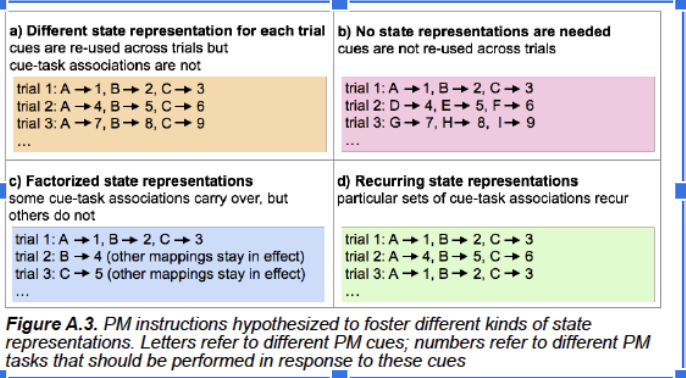

In [1]:
from glob import glob as glob
from itertools import product

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# train and eval
- no randomization (single emat)

In [3]:
## funs
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
                           
def train_model(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  variable sequence length training
  closed loop randomizing of embedding
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  acc = -np.ones(neps)
  for ep in range(neps):
    # forward prop
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen=seqlen,switchmaps=switchmaps)
    yhat_ulog = net(tseq,xseq)
    # eval
    trial_acc = np.mean((maxsoftmax(yhat_ulog) == ytarget).numpy())
    acc[ep] = trial_acc
    # backprop
    loss = 0
    for tstep in range(len(tseq)):
      loss += lossop(yhat_ulog[tstep],ytarget[tstep])
    optiop.zero_grad()
    loss.backward(retain_graph=True)
    optiop.step()
    if trial_acc>=.99:
      task.sample_emat()
  return acc

def eval_model(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.sample_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switchmaps)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

In [264]:
seed = np.random.randint(999)
stsize = 25
sdim = 10
ntokens = 3

task = PurePM(
        ntokens=ntokens,
        stimdim=sdim,
        seed=seed
)

net = PINet(
        stimdim=sdim,
        stsize=stsize,
        outdim=ntokens,
        nmaps=ntokens+1,
        seed=seed
)

net.EMBool = True

In [265]:
tr_neps = 100000
ntrials = 3
seqlen = 4
tr_switch = 1

tr_acc = train_model(net,task,tr_neps,ntrials,seqlen,tr_switch)

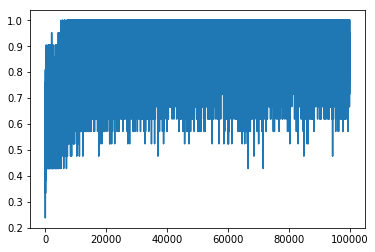

In [266]:
plt.plot(tr_acc)

(0, 1.05)

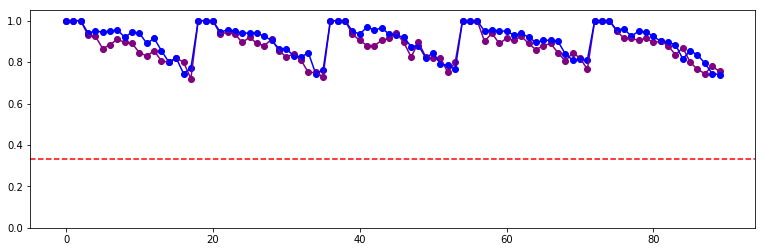

In [267]:
plt.figure(figsize=(13,4))
ev_neps = 200
ev_ntrials = 5
ev_seqlen = 15
ev_switch = 1
cL=['purple','b']
for em in [0,1]:
  net.EMbool = em
  score = eval_model(net,task,ev_neps,ev_ntrials,ev_seqlen,ev_switch)
  acc = score.mean(0)
  plt.plot(acc,c=cL[em])
  plt.scatter(range(len(acc)),acc,c=cL[em])
  
plt.axhline(1/ntokens,c='r',ls='--')
plt.ylim(0,1.05)
# plt.savefig('figures/EMconjcode/single_emat-5tokens-3seqlen')

# cluster data

### load net

In [2]:
def load_net(seed,trep,switch,ntokens,seqlen,ntrials):
  """ model names
  'LSTM_25'
  'LSTM_25-EM_0'
  'LSTM_25-EM_conjcode'
  """
  ##
  model_name = 'LSTM_25-EM_conjcode'
  model_dir = 'PITask_randstim' # PITask_many_ntokens
  trep *= 100000
  fpath = 'model_data/%s/'%model_dir
  fpath += "%s-ntokens_%i-seqlen_%i-ntrials_%i-switchmaps_%s-seed_%s-tr_%s-model.pt"%(
              model_name,ntokens,seqlen,ntrials,switch,seed,trep)
  net = PINet(
          stimdim=10,
          stsize=25,
          outdim=ntokens,
          nmaps=ntokens+1,
          seed=seed
  )
  # load
  net.load_state_dict(tr.load(fpath))
  return net


def load_netL(trep,switch,ntokens,seqlen,ntrials):
  netL = []
  for sd in range(20):
    try:
      net = load_net(sd,trep,switch,ntokens,seqlen,ntrials)
      netL.append(net)
    except:
      pass
  print('N =',len(netL),'loaded nets')
  return netL


def eval_net(net,task,neps,ntrials,seqlen,switch):
  """ 
  fixed sequence length eval
  new embedding for every episode
  returns score
  """
  maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.sample_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switch)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def eval_netL(netL,task,neps,ntrials,seqlen,switch=1,embool=1):
  """ returns acc `[sub,tsteps]`
  """
  nsubs = len(netL)
  tsteps = ntrials*(seqlen + task.ntokens)
  group_acc = np.ones([nsubs,tsteps]) 
  for sid,net in enumerate(netL):
    net.EMbool = embool
    evsc = eval_net(net,task,neps,ntrials,seqlen,switch)
    group_acc[sid] = evsc.mean(0)
  return group_acc
  


### train accuracy

In [5]:
def load_cat_tracc(ntokens,seqlen,ntrials,switchmap,seed):
  tracc = -np.ones(180000)
  for trep in np.arange(2,20,2):
    trep*=10000
    fpath = "LSTM_25-EM_conjcode-ntokens_%s-seqlen_%s-ntrials_%s-switchmaps_%s-seed_%s-tr_%s-tracc.npy"%(
                                ntokens,    seqlen,    ntrials,  switchmap, seed,trep)
    try:
      tracc[trep-20000:trep] = np.load('model_data/PITask/'+fpath)
    except:
      print('load er',fpath)
      continue 
  return tracc

def mov_avg(arr,wind):
  MA = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    MA[t] = arr[t:t+wind].mean()
  return MA

6 3 2 1
6 3 3 1
6 3 4 1
6 4 2 1
6 4 3 1
6 4 4 1
6 5 2 1
6 5 3 1
6 5 4 1
6 6 2 1
6 6 3 1
6 6 4 1
6 10 2 1
6 10 3 1
6 10 4 1


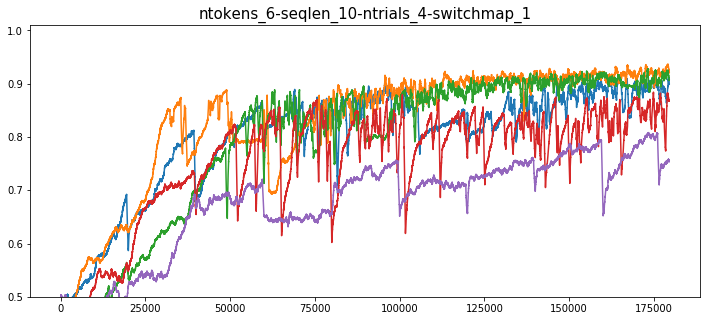

In [25]:
ntoL = np.arange(3,7)
slL = [3,4,5,6,10]
ntrL = [2,3,4]
switchL = [0,1]
seedL = np.arange(5)

ntoL = [3,6]
slL = [5]
switchL = [1]
# ntrL = [2,4]
ntoL = [6]

for ntokens,seqlen,ntrials,switchmap in product(ntoL,slL,ntrL,switchL):
  print(ntokens,seqlen,ntrials,switchmap)
  plt.close('all')
  plt.figure(figsize=(12,5))
  title = 'ntokens_%i-seqlen_%i-ntrials_%i-switchmap_%i'%(
    ntokens,seqlen,ntrials,switchmap)
  plt.title(title,fontsize=15)
  plt.ylim(0.5,1.01)
  for seed in seedL:
    tracc = load_cat_tracc(ntokens,seqlen,ntrials,switchmap,seed)
    tracc = mov_avg(tracc,500)
    plt.plot(tracc)
  plt.savefig('figures/PItask_sweep/train_acc/'+title)
  

### eval accuracy line plots

# PITask_many_ntokens

In [24]:
## init
trep = 1
switch = 1
ntokens = 8
seqlen = 8
ntrials = 2
netL = load_netL(trep,switch,ntokens,seqlen,ntrials)
task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 

N = 6 loaded nets


In [ ]:
## eval
ev_neps = 150
ev_ntrials = 5
ev_seqlen = 10
ev_switch = 1
ev_EM = 1
acc = eval_netL(netL,task,ev_neps,ev_ntrials,ev_seqlen,ev_switch,ev_EM)

In [ ]:
## plot
def plt_group_acc(ax,acc,c='blue',lab=None):
  """ acc [Nnets,time]
  """
  M = acc.mean(0)
  S = acc.std(0)/np.sqrt(len(acc))
  for subacc in acc:
    plt.plot(subacc,lw=.1,c=c)
  ax.plot(M,c=c,label=lab)
  ax.scatter(range(len(M)),M,c=c)
  ax.set_ylim(0,1.01)
  ax.set_ylabel('eval accuracy')
  return None

trep = 5
switch = 1
ev_neps = 500
ev_ntrials = 8
ev_seqlen = 5
ev_switch = 1

# ntoL = [6,7,8,10]
# slL = [2,8,15]
# ntL  = [2,5,10,15]

ntoL = [10]
slL = [5,15]
ntL  = [2,4]


for ntokens,seqlen in product(ntoL,slL):
  plt.figure(figsize=(30,6))
  ax = plt.gca()
  for ntrials in ntL:
    # load netL and init task
    netL = load_netL(trep,switch,ntokens,seqlen,ntrials)
    task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 
    for ev_em,c in zip([0,1],[plt.cm.Reds,plt.cm.Blues]):
      # eval nets
      acc = eval_netL(netL,task,ev_neps,ev_ntrials,ev_seqlen,ev_switch,ev_em)
      plt_group_acc(ax,acc,c=c((ntrials+3)*25))
      # save eval data
      fpath = "model_data/PIsweep-eval_data/lstm25-EM_%i-switch_%i-ntokens_%i-ntrials_%i-seqlen_%i"%(
        ev_em,switch,ntokens,ntrials,seqlen)
      np.save(fpath,acc)
  # figure titles    
  title = "lstm25-switch_%i-ntokens_%i-seqlen_%i-trep_%i"%(switch,ntokens,seqlen,trep)
  print('done:',title)
  ax.axhline(1/ntokens,c='green',ls='--',lw=.5)
  plt.title(title)
#   plt.legend(loc=3)
  plt.savefig('figures/PItask_sweep/rand_stim/'+title)
  plt.close('all')
#   assert False


N = 10 loaded nets
N = 10 loaded nets


In [18]:
def load_tracc(seed,ntokens,ntrials,seqlen,max_trep=10):
  tracc = []
  for trep in range(1,max_trep):
    trep *= 100000
    fpath = "model_data/PITask_randstim/LSTM_25-EM_conjcode-ntokens_%s-seqlen_%s-ntrials_%s-switchmaps_%s-seed_%s-tr_%s-tracc.npy"%(
                    ntokens,seqlen,ntrials,1,seed,trep)
    tracc.append(np.load(fpath))
  return np.concatenate(tracc)

def mov_avg(arr,wind):
  MA = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    MA[t] = arr[t:t+wind].mean()
  return MA

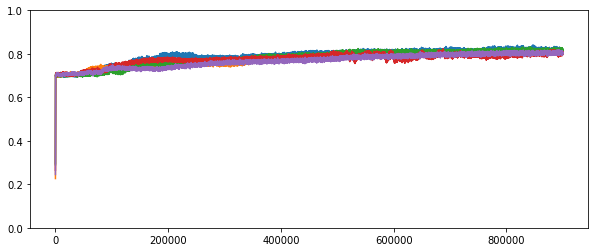

In [26]:
plt.figure(figsize=(10,4))
plt.ylim(0,1)

# seed = 0
ntokens = 10
ntrials = 4
seqlen = 5

for seed in range(5):
  tracc = load_tracc(seed,ntokens,ntrials,seqlen)
  plt.plot(mov_avg(tracc,100))
  
# plt.savefig('figures/PItask_sweep/tracc-ntokens10-ntrials15-seqlen8')

# PITask_randstim

In [22]:
def load_tracc(seed,ntokens,ntrials,seqlen,verb=False):
  tracc = []
  for trep in range(1,10):
    trep *= 100000
    fpath = "model_data/PITask_randstim/LSTM_25-EM_conjcode-ntokens_%s-seqlen_%s-ntrials_%s-switchmaps_%s-seed_%s-tr_%s-tracc.npy"%(
                    ntokens,seqlen,ntrials,1,seed,trep)
    try:
      tracc.append(np.load(fpath))
    except:
      if verb:
        print('er',fpath)
      pass
  return np.concatenate(tracc)

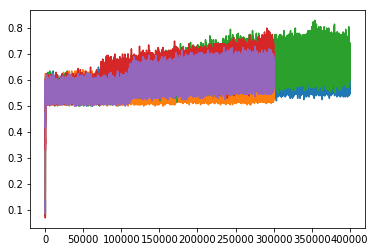

In [30]:
for seed in range(1,6):
  tracc = load_tracc(seed,10,10,10,verb=False)
  plt.plot(tracc)

In [ ]:
load_net()

# FIRST SWEEP - outdated fun use

N = 20 loaded nets


KeyboardInterrupt: 

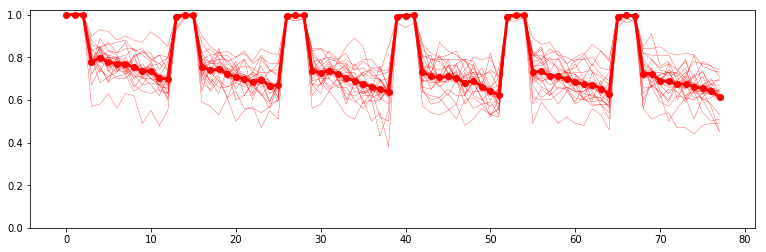

In [4]:
nitEM = 1
trep = 12
neps = 100
ev_switch = 1
ev_seqlen = 10
ev_ntrials = 6

for switch,ntokens,seqlen,ntrials in product(np.arange(2),np.arange(3,7),np.arange(3,6),np.arange(2,5)):
  
  netL = load_netL(trep,switch,ntokens,seqlen,ntrials)
  task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 

  plt.close('all')
  plt.figure(figsize=(13,4))
  ax = plt.gca()
  ax.set_ylim(0,1.02)

  cL = ['r','b']
  labL = ['EM=0','EM=1']

  for eval_EM in [0,1]:
    # switch EM and eval
    acc = eval_netL(netL,task,neps,ev_ntrials,ev_seqlen,ev_switch,eval_EM)
    # group stats
    M = acc.mean(0)
    S = acc.std(0)/np.sqrt(len(acc))
    # plot
    ax.plot(M,c=cL[eval_EM],lw=3,label=labL[eval_EM])
    ax.scatter(range(len(M)),M,c=cL[eval_EM])
    ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color=cL[eval_EM])
    # sub plot
    for subacc in acc:
      ax.plot(subacc,c=cL[eval_EM],lw=.3)
  
  ax.axhline(1/ntokens,c='purple',lw=.5,ls='--')
  # label and save
  plt.legend(loc=0)
  groupname="switch_%i-ntokens_%i-ntrials_%i-seqlen_%i-trep_%i"%(switch,ntokens,ntrials,seqlen,trep)
  ax.set_title('train_params: '+groupname+'\neval_params: switch_%s'%(ev_switch))
  plt.savefig('figures/PItask_sweep/'+groupname)

### bar plots

N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loade

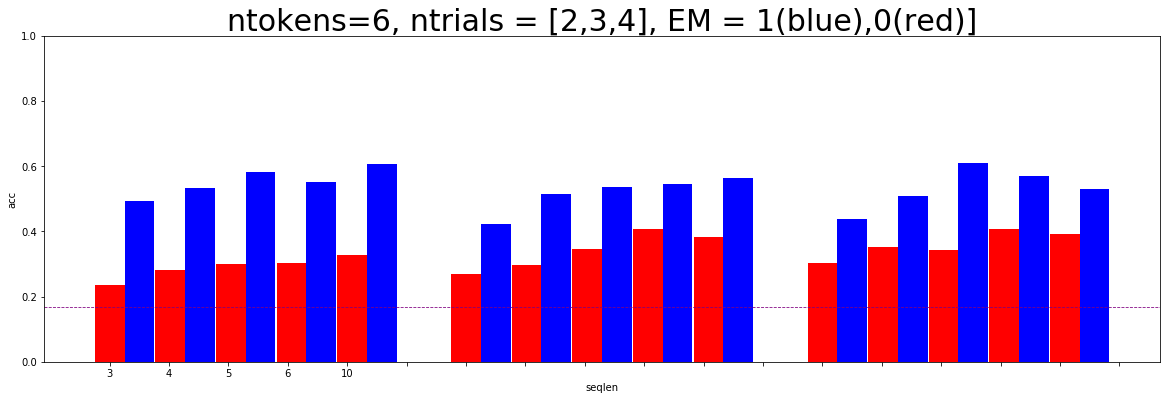

In [33]:
embool = 1
trep = 12
switch = 1
model_name = 'LSTM_25-EM_conjcode'

# ev params
neps = 300
ev_ntrials = 1
ev_seqlen = 20
ev_switch = 1

ntokensL = [3,4,5,6] # different figures
ntrialsL = [2,3,4] # x-axis lv 1
seqlenL = [3,4,5,6,10] # x-axis lv 2

for ntokens in ntokensL:
  plt.close('all')
  plt.figure(figsize=(20,6))
  ax = plt.gca()
  ax.set_ylim(0,1)
  ax.axhline(1/ntokens,lw=.8,ls='--',c='purple')

  bw = 1/12
  cL = ['r','b']
  ax.set_xticks(np.arange(0,3,bw*2))
  ax.set_xticklabels(seqlenL)
  ax.set_title("ntokens=%i, ntrials = [2,3,4], EM = 1(blue),0(red)]"%(ntokens),fontsize=30)
  ax.set_xlabel('seqlen')
  ax.set_ylabel('acc')

  for (nt_idx,ntrials),(sl_idx,seqlen) in product(enumerate(ntrialsL),enumerate(seqlenL)):
    netL = load_netL(trep,switch,ntokens,model_name,seqlen,ntrials)
    task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 
    for embool in [0,1]:
      acc_arr = eval_netL(netL,embool,task,neps,ev_ntrials,ev_seqlen,ev_switch)
      mean_acc = acc_arr[:,ntokens:].mean()
      xtick = nt_idx + 0.85*sl_idx*(1/len(seqlenL)) + bw*embool
      ax.bar(xtick,mean_acc,width=bw,color=cL[embool])

  plt.savefig('figures/PItask_sweep/bar_meanacc_%intokens-%itrep'%(ntokens,trep))

# exploring different EM structures

### load model: percept FF layer, conjunctive (FF+main_cell) EM keys

N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets
N = 20 loaded nets


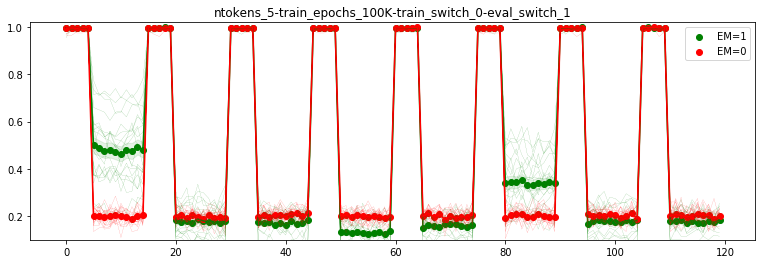

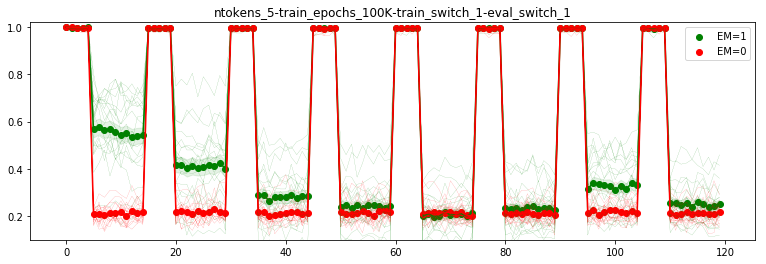

In [51]:
plt.close('all')

# task params
for tr_switch in [0,1]:
  ev_switch = 1

  # train params
  model_name = 'LSTM_25-EM_conjcode'
  ntokens = 5
  tr_seqlen = 5
  treps = 1

  # eval
  neps = 200
  ntrials = 8
  seqlen = 10

  # load netL 
  netL_EM1 = load_netL(treps,tr_switch,ntokens,model_name,tr_seqlen)
  netL_EM0 = load_netL(treps,tr_switch,ntokens,model_name,tr_seqlen)
  # init task
  task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 

  # fig
  cL = ['g','r']
  labL = ['EM=1','EM=0']
  plt.figure(figsize=(13,4))
  ax = plt.gca()
  ax.set_ylim(0.1,1.02)

  # eval, process and plot
  for idx,netL in enumerate([netL_EM1,netL_EM0]):
    acc = eval_netL(netL,task,neps,ntrials,seqlen,ev_switch)
    M = acc.mean(0)
    S = acc.std(0) / np.sqrt(len(acc))
    T = len(M)
    ax.plot(M,c=cL[idx])
    ax.scatter(range(T),M,c=cL[idx],label=labL[idx])
    ax.fill_between(range(T),M-S,M+S,alpha=.1,color=cL[idx])
    for sacc in acc:
      ax.plot(sacc,lw=.1,c=cL[idx])

  # save
  plt.legend(loc=1)
  fname = "ntokens_%i-train_epochs_%i00K-train_switch_%i-eval_switch_%i"%(
            ntokens,treps,tr_switch,ev_switch)
  plt.title(fname)
  plt.savefig('figures/EMbuckets/'+fname)


### in search of buckets: 
- networks in tr_switch=1 should show evidence of context shift / representational buckets

In [35]:
## params
tr_switchL = [0,1]
model_name = 'LSTM_25-EM_conjcode'
ntokens = 5
tr_seqlen = 5
treps = 1

# eval
ev_switch = 1
neps = 20
ntrials = 8
seqlen = 10

In [37]:
task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 

for tr_switch in tr_switchL:
  netL = load_netL(treps,tr_switch,ntokens,model_name,tr_seqlen)
  

N = 20 loaded nets
N = 20 loaded nets


### tbt RSA

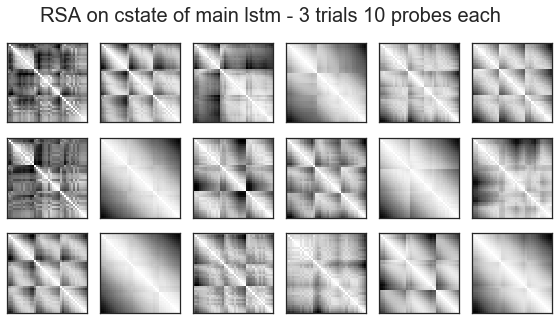

In [331]:
from scipy.spatial.distance import cdist
ntrials = 3
seqlen = 10
ev_switch = 1

fig,axarr=plt.subplots(3,6, figsize=(10,10),sharex=True,sharey=True);

tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,ev_switch)

for net,ax in zip(netL,axarr.reshape(-1)):
  yhat = net(tseq,xseq)
  st_traj = np.array(net.cstateL)
  RSM = cdist(st_traj,st_traj,metric='euclidean')
  ax.imshow(RSM,cmap='Greys')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
plt.suptitle('RSA on cstate of main lstm - 3 trials 10 probes each',y=.55,fontsize=20)
plt.subplots_adjust(top=0.5,wspace=0)
plt.savefig('figures/EMconjcode/cstate_tbtRSA')

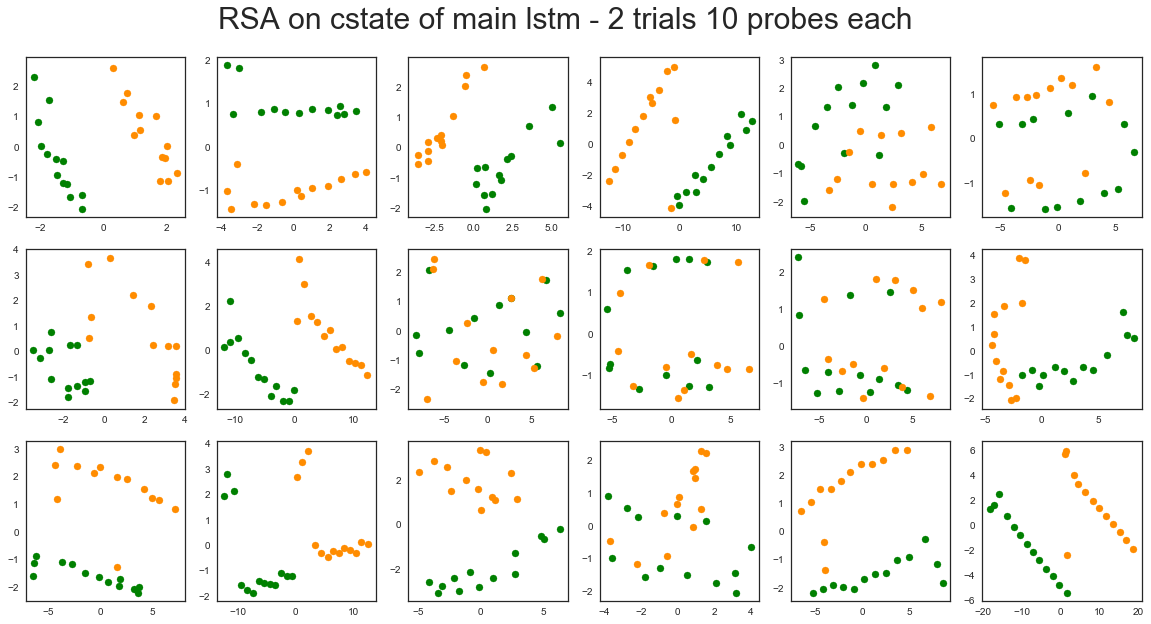

In [334]:
from sklearn.decomposition import PCA

fig,axarr=plt.subplots(3,6, figsize=(20,10));

ntrials = 2
seqlen = 10
tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,ev_switch)

pca = PCA(2)

for net,ax in zip(netL,axarr.reshape(-1)):
  yhat = net(tseq,xseq)
  st_traj = np.array(net.cstateL)
  pc_cst = pca.fit_transform(st_traj)
  T = pc_cst.shape[0]
  t = int(T/2)
  ax.scatter(pc_cst[:t,0],pc_cst[:t,1],c='g')
  ax.scatter(pc_cst[-t:,0],pc_cst[-t:,1],c='darkorange')

plt.suptitle('RSA on cstate of main lstm - 2 trials 10 probes each',y=.95,fontsize=30)
plt.savefig('figures/EMconjcode/cstate_PCA_scatter')

## load model: trained without EM

N = 20 loaded nets
N = 20 loaded nets


Text(0.5,1,'identical networks trained with vs without EM\n during eval EM=0 for both groups')

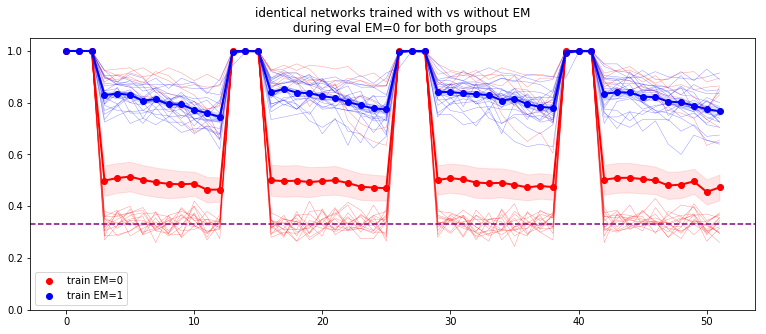

In [7]:
# train params
treps = 1
tr_switch = 1
ntokens = 3

# eval params
neps = 200
ntrials = 4
seqlen = 10
ev_switch = 1

plt.figure(figsize=(13,5))
ax = plt.gca()

model_names = ['LSTM_25-EM_0','LSTM_25-EM_conjcode']
labL = ['train EM=0','train EM=1']
cL = ['r','b']

for idx,mn in enumerate(model_names):
  # init model and tarsk
  netL = load_netL(treps,tr_switch,ntokens,mn)
  task = PurePM(ntokens=ntokens,stimdim=10,seed=np.random.randint(999)) 
  # accuracy stats
  acc = eval_netL(netL,task,neps,ntrials,seqlen,ev_switch)
  M = acc.mean(0)
  N,T = acc.shape
  S = acc.std(0)/np.sqrt(N)
  ## plot
  ax.plot(M,c=cL[idx],lw=2)
  ax.scatter(range(T),M,c=cL[idx],label=labL[idx])
  ax.fill_between(range(T),M-S,M+S,alpha=.1,color=cL[idx])
  for sacc in acc:
    ax.plot(sacc,alpha=.4,c=cL[idx],lw=.5)

ax.axhline(1/ntokens,c='purple',ls='--')
ax.set_ylim(0,1.05)
plt.legend()
plt.title('identical networks trained with vs without EM\n during eval EM=0 for both groups')
# plt.savefig('figures/EM0/comapre_train_with_vs_without_EM')

## load model: percept is LSTM layer, EM is {percept_lstm : main_lstm}

In [159]:
# init task
task = PurePM(
        ntokens=3,
        stimdim=10,
        seed=np.random.randint(999)
)

# list of networks
trep = 6
switch_train = 0
# with and without EM
netL_em0 = load_netL(trep,switch_train)
netL_em1 = load_netL(trep,switch_train)

N = 20 loaded nets
N = 20 loaded nets


In [162]:
neps = 500
ntrials = 5
seqlen = 5
switch_eval = 1

acc_em0 = eval_netL(netL_em0,task,neps,ntrials,seqlen,switch_eval)
acc_em1 = eval_netL(netL_em1,task,neps,ntrials,seqlen,switch_eval)

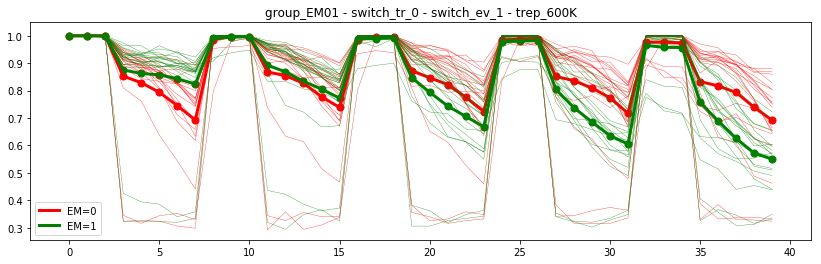

In [164]:
plt.figure(figsize=(14,4))
ax = plt.gca()
cL = ['r','g']
labL = ['EM=0','EM=1']

for gidx,acc in enumerate([acc_em0,acc_em1]):
  for sub_acc in acc:
    ax.plot(sub_acc,lw=.3,c=cL[gidx])
  ax.plot(acc.mean(0),c=cL[gidx],lw=3,label=labL[gidx])
  ax.scatter(range(acc.shape[1]),acc.mean(0),c=cL[gidx],s=50)
  
plt.legend()
title = "group_EM01-switch_tr_%i-switch_ev_%i-trep_%s00K"%(switch_train,switch_eval,trep)
plt.title(' - '.join(title.split('-')))
plt.savefig('figures/PIsweep_EM/'+title)

# debug

# Cluster script